In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
# PATH
# example path
path = "C:/Users/HUY/Desktop/my_project/data/001/bg-01/090"

# others path
root_folder = "C:/Users/HUY/Desktop/my_project/data"
bulk = "C:/Users/HUY/Desktop/my_project/bulk"
final_data = "C:/Users/HUY/Desktop/my_project/final_data"
synthetic_path = "C:/Users/HUY/Desktop/my_project/synthetic_data"


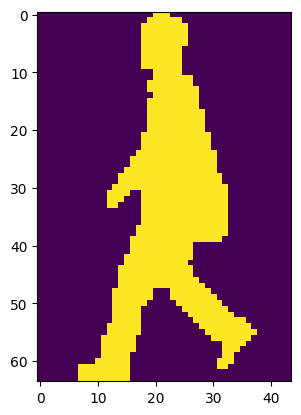

In [12]:
# 1. Preprocess silhouettes (đã test xong) chạy oke
# chuyển ảnh silhoute thành ảnh nhị phân trắng đen

def preprocess_silhouettes(folder_path):
    silhouettes = []
    # tạo danh sách đường dẫn của tất cả ảnh trong folder
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_paths: # kiểm tra đường dẫn hợp lệlệ
        raise ValueError("No valid image files found in the folder.")
    
    for path in image_paths: # đọc mỗi tấm ảnh và lấy ngưỡng cho nó
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"⚠️ Warning: Cannot read image at {path}")
            break
        
        _, binary = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
        
        binary = binary[:,10:-10] # crop ảnh từ 64x64 thành 64x44
        silhouettes.append(binary)
        
    return np.array(silhouettes)

# test
sil = preprocess_silhouettes(path)
sil.shape
plt.imshow(sil[5]) # OKE

(64, 44)


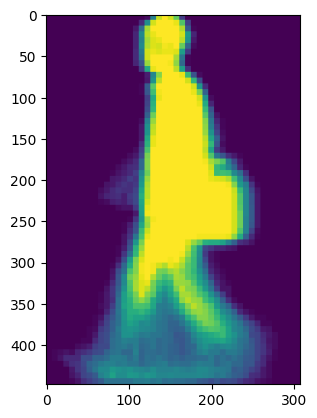

In [13]:
# 2. Compute Gait Energy Image
# sử dụng ảnh silhoute trắng đen trước đó để tính ảnh GEI
def compute_gei(silhouettes):
    return np.mean(silhouettes, axis=0)

gei = compute_gei(sil)
print(gei.shape) # OKE

def show_image(image, title="Image", scale=7):
    h, w = image.shape[0], image.shape[1]
    resized_image = cv2.resize(image, (w * scale, h * scale), interpolation=cv2.INTER_NEAREST)
    plt.imshow(resized_image)
    
show_image(gei) # OKE

In [14]:
# lưu ảnh vào thư mục đã chọn
def save_image(image, folder_path, image_name):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    save_path = f"{folder_path}/{image_name}"
    cv2.imwrite(save_path, image)
    # print(f"Image saved at {save_path}")

In [ ]:
# hàm xử lý ảnh GEI back

def gei_process(root_folder, bulk):
    for object in tqdm(os.listdir(root_folder)):
        for folder in os.listdir(f"{root_folder}/{object}"):
            for direction in os.listdir(f"{root_folder}/{object}/{folder}"):
                binary_imgs = preprocess_silhouettes(f"{root_folder}/{object}/{folder}/{direction}")
                gei = compute_gei(binary_imgs)
                save_image((gei*255).astype(np.uint8), bulk, f"{object}-{folder}-{direction}.jpg")
    print("✅ Processed all Gait Energy imgs!")
    
gei_process(root_folder, bulk) # OKE

100%|██████████| 10/10 [01:07<00:00,  6.72s/it]

✅ Processed all Gait Energy imgs!


# !!! CHỈNH ĐOẠN CODE PHÍA DƯỚI ĐỂ CHIA DỮ LIỆU TRAIN VÀ TEST

In [16]:
def split_data(bulk, final_path):
    # tạo folder lưu trữ dữ liệu
    if not os.path.exists(final_path):
        os.makedirs(final_path)
    # tạo nơi lưu trữ tập huấn luyện
    train_path = f"{final_path}/train"
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    # tạo nơi lưu trữ tập kiểm tra
    test_path = f"{final_path}/test"
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    for img in tqdm(os.listdir(bulk)):
        if "nm-01" in img or "nm-02" in img or "nm-03" in img or "nm-04" in img  or "cl-01" in img or "bg-01" in img:
            im = cv2.imread(f"{bulk}/{img}", cv2.IMREAD_GRAYSCALE)
            save_image(im,train_path,img)
            
        if "nm-05" in img or "nm-06" in img or "cl-02" in img  or "bg-02" in img:
            im = cv2.imread(f"{bulk}/{img}", cv2.IMREAD_GRAYSCALE)
            save_image(im,test_path,img)

    print("✅ Splitted all the data into train and test sets.")
    
split_data(bulk, final_data) # OKE

100%|██████████| 1100/1100 [00:15<00:00, 69.29it/s]

✅ Splitted all the data into train and test sets.


In [17]:
# tạo thêm ra các ảnh synthetic để làm cho bộ dữ liệu lớn hơn chút

def create_synthetic(final_data, synthetic_path, iter = 3, k = 2):
    train_path =  f"{synthetic_path}/train"
    test_path = f"{synthetic_path}/test"
    if not os.path.exists(synthetic_path):
        os.makedirs(synthetic_path)
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    for folder in os.listdir(final_data):
        print(f"Creating synthetic images for {folder}")
        for im in tqdm(os.listdir(f"{final_data}/{folder}")):
            image = cv2.imread(f"{final_data}/{folder}/{im}", cv2.IMREAD_GRAYSCALE)
            x, y = image.shape
            for i in range(1, 1 + iter):
                temp = np.copy(image)
                
                cut_bot = temp[0:x-i*k, :]
                cut_top = temp[i*k:x, :]
                
                cut_bot = cv2.resize(cut_bot, (y,x))
                cut_top = cv2.resize(cut_top, (y,x))
                
                im = im[0:13]
                if folder == "train": path = train_path
                else: path = test_path
                
                save_image(cut_bot, path , f"{im}-t-{i}.jpg ")
                # print({cut_bot.shape})
                save_image(cut_top, path, f"{im}-t-{i+iter}.jpg ")
                # print({cut_top.shape})
            
    print("✅ Finished creating synthetic images")
            

create_synthetic(final_data, synthetic_path)

# số dữ liệu khá chuẩn theo tính toán, có điều dữ liệu người số năm bị thiếu góc chính diện 

Creating synthetic images for test


100%|██████████| 440/440 [00:10<00:00, 42.51it/s]


Creating synthetic images for train


100%|██████████| 660/660 [00:13<00:00, 47.74it/s]

✅ Finished creating synthetic images


In [ ]:
# HOÀN THÀNH TIỀN XỬ LÝ DỮ LIỆU
# > chia dữ liệu ra 2 tập train và test
# > tạo thêm 12 ảnh tổng hợp cho mỗi ảnh dữ liệu gốc
# > và chia ra thành các train và test

In [10]:
import shutil

def clear_folder(folder_path):
    if not os.path.isdir(folder_path):
        print(f"❌ '{folder_path}' is not a valid directory.")
        return

    for item in tqdm(os.listdir(folder_path)):
        item_path = os.path.join(folder_path, item)
        try:
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.remove(item_path)  # delete file or symbolic link
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)  # delete folder and its contents
        except Exception as e:
            print(f"⚠️ Error deleting '{item_path}': {e}")

    print(f"✅ All contents of '{folder_path}' have been deleted.")

In [11]:
clear_folder(bulk)
clear_folder(final_data)
clear_folder(synthetic_path)

0it [00:00, ?it/s]


✅ All contents of 'C:/Users/HUY/Desktop/my_project/bulk' have been deleted.


0it [00:00, ?it/s]


✅ All contents of 'C:/Users/HUY/Desktop/my_project/final_data' have been deleted.


0it [00:00, ?it/s]

✅ All contents of 'C:/Users/HUY/Desktop/my_project/synthetic_data' have been deleted.
